# Modul 1 - Mengimplementasikan NN dasar menggunakan library Python


## Tujuan Modul:
1. Mengenalkan cara kerja Jaringan Syaraf Tiruan
2. Mengimplementasikan Jaringan Syaraf Tiruan untuk Klasifikasi Data Citra Sederhana


In [1]:
%matplotlib inline

# Klasifikasi angka/digit tulisan tangan

### Mengambil dan menyiapkan dataset MNIST

Dataset MNIST tersedia secara publik di http://yann.lecun.com/exdb/mnist/ dan terdiri dari empat bagian berikut:
- Gambar set pelatihan: train-images-idx3-ubyte.gz (9,9 MB, 47 MB setelah diekstrak, 60.000 contoh)
- Label set pelatihan: train-labels-idx1-ubyte.gz (29 KB, 60 KB setelah diekstrak, 60.000 label)
- Gambar set pengujian: t10k-images-idx3-ubyte.gz (1,6 MB, 7,8 MB, 10.000 contoh)
- Label set pengujian: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB setelah diekstrak, 10.000 label)

Catatan: Ekstrak = unzip bagi yang tidak familiar dengan istilah ini.



In [2]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### Normalisasi ke rentang [-1, 1]:

In [3]:
X = ((X / 255.) - .5) * 2

### Memvisualisasikan digit pertama dari setiap kelas:

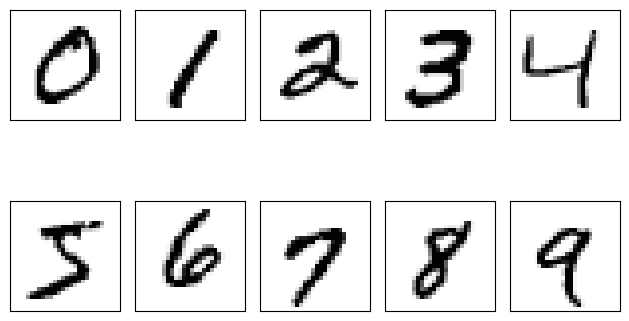

In [4]:
import matplotlib.pyplot as plt # Silakan diisi bagian ini dengan kode yang tepat (5)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Memvisualisasikan 25 versi berbeda dari digit "7":

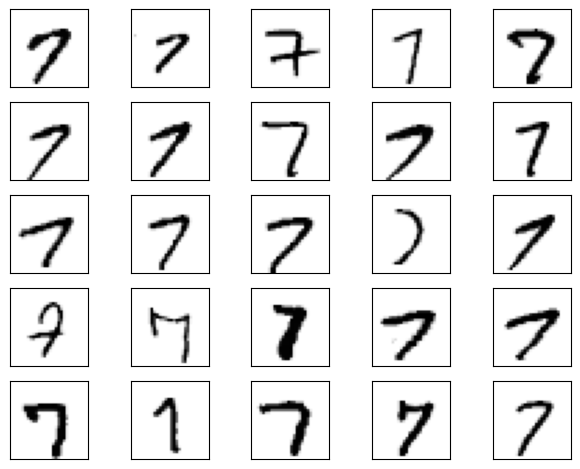

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)   # Silakan diisi bagian ini dengan kode yang tepat (10)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Memisahkan dataset menjadi set pelatihan, validasi, dan pengujian:

In [6]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1000, random_state=123, stratify=y
) # Silakan diisi bagian ini dengan kode yang tepat (10)


# opsinal untuk mengosongkan memori dengan menghapus array yang tidak digunakan:
del X_temp, y_temp, X, y

## Mengimplementasikan multi-layer perceptron

In [7]:
import numpy as np

### Implementasi MLP secara Object Oriented

Kode berikut ini merupakan implementasi sederhana dari jaringan syaraf tiruan tipe **Multilayer Perceptron (MLP)** dengan satu lapisan tersembunyi dan fungsi aktivasi **sigmoid**. Pertama, terdapat fungsi `sigmoid(z)` yang digunakan untuk mengubah input numerik ke dalam rentang nilai antara 0 hingga 1, serta fungsi `int_to_onehot(y, num_labels)` yang mengonversi label kelas dalam bentuk bilangan bulat menjadi representasi **one-hot encoding** sehingga dapat digunakan dalam proses perhitungan loss.

Kelas `NeuralNetMLP` menjadi inti dari implementasi ini. Pada tahap inisialisasi (`__init__`), jaringan dibangun dengan parameter berupa jumlah fitur (input), jumlah unit pada hidden layer, jumlah kelas output, serta seed acak untuk inisialisasi bobot. Bobot untuk lapisan tersembunyi (`weight_h`) dan lapisan keluaran (`weight_out`) diinisialisasi menggunakan distribusi normal dengan nilai kecil, sementara bias (`bias_h` dan `bias_out`) diinisialisasi dengan nol. Struktur bobot ini menentukan bagaimana input akan diproyeksikan ke hidden layer dan kemudian ke output layer.

Metode `forward(x)` menjalankan proses **propagasi maju (forward pass)**. Input data dikalikan dengan bobot lapisan tersembunyi dan ditambahkan dengan bias untuk menghasilkan nilai linear (`z_h`), kemudian dilewatkan ke fungsi sigmoid sehingga menghasilkan aktivasi (`a_h`). Aktivasi hidden layer ini selanjutnya digunakan sebagai input ke lapisan keluaran untuk menghasilkan nilai prediksi (`a_out`).

Selanjutnya, metode `backward(x, a_h, a_out, y)` berfungsi untuk menjalankan **propagasi balik (backpropagation)** guna menghitung gradien atau turunan parsial terhadap bobot dan bias. Proses ini dimulai dari lapisan keluaran dengan menghitung selisih antara output prediksi (`a_out`) dan label sebenarnya dalam bentuk one-hot (`y_onehot`). Dengan menggunakan turunan fungsi sigmoid, diperoleh error di output layer (`delta_out`). Gradien bobot dan bias lapisan keluaran kemudian dihitung dengan mengalikan error tersebut dengan aktivasi hidden layer. Error dari output layer juga dibawa kembali (backpropagated) ke hidden layer melalui bobot keluaran untuk menghitung error di hidden layer (`delta_h`). Dengan cara serupa, gradien bobot dan bias hidden layer diperoleh dari perkalian antara error hidden dengan input asli. Hasil akhirnya berupa empat gradien utama: gradien bobot keluaran, gradien bias keluaran, gradien bobot hidden, dan gradien bias hidden, yang akan digunakan untuk memperbarui bobot dalam proses training.

Secara keseluruhan, kode ini menunjukkan alur dasar jaringan syaraf tiruan: mulai dari inisialisasi bobot, melakukan forward pass untuk menghitung output, kemudian backward pass untuk menghitung error dan gradien. Walaupun sederhana, implementasi ini sudah mencakup inti dari cara kerja MLP dalam pembelajaran mesin.


In [8]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # lapisan tersembunyi (Hidden layer)
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)) # Ini akan menghasilkan matriks bobot (weight) dengan dimensi [n_hidden, n_features]
        self.bias_h = np.zeros(num_hidden)
        
        # lapisan keluaran (Output layer)
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Lapisan tersembunyi (Hidden layer)
        # dimensi input: [n_examples, n_features] dot [n_hidden, n_features].T
        # dimensi output: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Lapisan keluaran (Output layer)
        # dimensi input: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # dimensi output: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
    
        #########################
        ### Bobot lapisan keluaran (Output layer weights)
        #########################
        
        # representasi one-hot (one-hot encoding)
        y_onehot = int_to_onehot(y, self.num_classes)

        # Bagian 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## di mana DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## untuk mempermudah penggunaan kembali (re-use)
        
        # dimensi input/output: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # dimensi input/output: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # turunan fungsi sigmoid (sigmoid derivative)

        # dimensi output: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "placeholder aturan delta (delta rule)"

        # gradien untuk bobot keluaran (output weights)
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # dimensi input: [n_classes, n_examples] dot [n_examples, n_hidden]
        # dimensi output: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################
        # Bagian 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # dimensi output: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # turunan fungsi sigmoid (sigmoid derivative)
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # dimensi output: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)


In [9]:
model = NeuralNetMLP(num_features=784, num_hidden=50, num_classes=10) # Silakan diisi bagian ini dengan kode yang tepat (10)



### Membuat kode loop pelatihan jaringan saraf tiruan

Defenisikan data loaders:

Kode di bawah ini merupakan proses **training model** menggunakan pendekatan **minibatch gradient descent**. Pertama, ditentukan dua parameter utama: `num_epochs = 50`, yang menyatakan bahwa pelatihan akan berlangsung selama 50 siklus penuh (epoch), dan `minibatch_size = 100`, yang artinya data latih akan dibagi menjadi kelompok kecil berisi 100 sampel pada setiap iterasi.

Fungsi `minibatch_generator(X, y, minibatch_size)` bertugas untuk membagi dataset menjadi minibatch. Caranya, fungsi ini terlebih dahulu membuat array indeks dari semua data, kemudian mengacak urutan indeks dengan `np.random.shuffle(indices)` agar minibatch yang terbentuk bersifat acak dan tidak selalu sama urutannya. Setelah itu, fungsi menggunakan perulangan `for start_idx in range(...)` untuk mengambil potongan indeks sesuai ukuran minibatch (`minibatch_size`). Dengan cara ini, setiap kali fungsi dipanggil, ia akan menghasilkan (`yield`) sepasang potongan data fitur (`X[batch_idx]`) dan label (`y[batch_idx]`) yang siap digunakan dalam proses training.

Selanjutnya, kode utama menjalankan perulangan **epoch** melalui `for i in range(num_epochs):`, yang berarti model akan melakukan training penuh sebanyak jumlah epoch yang ditentukan. Di dalamnya, dibuat generator minibatch dengan memanggil `minibatch_generator(X_train, y_train, minibatch_size)`. Generator ini kemudian diiterasi dengan perulangan `for X_train_mini, y_train_mini in minibatch_gen:`, sehingga pada setiap iterasi diperoleh satu minibatch data latih dan label yang bisa dipakai untuk update parameter model.

Namun, dalam kode ini terdapat perintah `break` pada loop minibatch, sehingga perulangan hanya akan mengambil **satu minibatch pertama** dari data latih pada epoch tersebut. Kemudian ada `break` kedua pada loop epoch, yang menyebabkan proses training hanya berhenti pada **epoch pertama saja**. Dengan kata lain, meskipun ditentukan `num_epochs = 50`, kode ini hanya akan mengambil **1 minibatch dari epoch pertama** lalu langsung keluar. Hal ini kemungkinan besar hanya untuk **tujuan pengujian (debugging)**, agar programmer bisa memastikan bahwa fungsi `minibatch_generator` berjalan dengan benar sebelum dipakai untuk training penuh.

In [10]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# melakukan iterasi (perulangan) pada training epochs (jumlah siklus pelatihan)
for i in range(num_epochs):

    # melakukan iterasi pada minibatches (potongan kecil data latih)
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size) # Silakan diisi bagian ini dengan kode yang tepat (10)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [11]:
### Mendefinisikan fungsi untuk menghitung nilai kerugian (loss) dan akurasi

Kode berikut digunakan untuk **evaluasi performa model** setelah proses training selesai, dengan menghitung **loss** dan **akurasi** pada data validasi.

Pertama, didefinisikan fungsi `mse_loss(targets, probas, num_labels=10)`. Fungsi ini menghitung **Mean Squared Error (MSE)** antara label sebenarnya dan output probabilitas dari model. Karena label target biasanya berupa bilangan bulat (misalnya 0, 1, 2 untuk klasifikasi digit), fungsi `int_to_onehot` dipanggil untuk mengubahnya menjadi representasi **one-hot encoding**. Selanjutnya, selisih antara vektor one-hot target dan probabilitas prediksi (`probas`) dihitung, lalu dipangkatkan dua dan dirata-ratakan menggunakan `np.mean`. Nilai MSE ini menunjukkan seberapa jauh distribusi probabilitas prediksi model dari label yang benar, di mana nilai yang lebih kecil berarti prediksi model semakin akurat.

Kedua, terdapat fungsi `accuracy(targets, predicted_labels)` yang digunakan untuk menghitung tingkat akurasi prediksi. Akurasi dihitung dengan membandingkan label prediksi (`predicted_labels`) dengan label sebenarnya (`targets`). Jika prediksi sama dengan target, hasilnya `True` (yang dihitung sebagai 1), jika berbeda maka `False` (dihitung sebagai 0). Nilai rata-ratanya (`np.mean`) memberikan proporsi prediksi yang benar, sehingga diperoleh nilai akurasi antara 0 dan 1.

Bagian eksekusi kode berikutnya menjalankan evaluasi pada data validasi. Pertama, `model.forward(X_valid)` dipanggil untuk melakukan **forward pass** pada data validasi (`X_valid`), dan hasilnya adalah aktivasi output berupa probabilitas (`probas`). Fungsi `mse_loss` kemudian digunakan untuk menghitung nilai MSE dengan `y_valid` sebagai label target dan `probas` sebagai hasil prediksi probabilitas. Selanjutnya, `np.argmax(probas, axis=1)` digunakan untuk mengambil label kelas dengan probabilitas tertinggi sebagai prediksi akhir (`predicted_labels`). Prediksi ini dibandingkan dengan label sebenarnya (`y_valid`) menggunakan fungsi `accuracy` untuk menghitung nilai akurasi (`acc`).

Dengan demikian, kode ini memberikan dua metrik evaluasi:

* **MSE (Mean Squared Error):** mengukur selisih kuadrat antara distribusi probabilitas prediksi dan label target.
* **Accuracy:** mengukur proporsi prediksi yang tepat terhadap seluruh data validasi.



In [12]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas, num_labels=10) # Silakan diisi bagian ini dengan kode yang tepat (10)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels) # Silakan diisi bagian ini dengan kode yang tepat (10)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 10.0%


### Menggabungkan fungsi untuk menghitung nilai kerugian (loss) dan akurasi

Kode di bawah ini berfungsi untuk menghitung **nilai rata-rata MSE (Mean Squared Error)** dan **akurasi** dari model (`nnet`) pada suatu dataset (`X`, `y`) dengan cara memproses data dalam bentuk **minibatch**. Hal ini berguna ketika dataset berukuran besar sehingga tidak efisien untuk diproses sekaligus.

Fungsi `compute_mse_and_acc` menerima beberapa parameter:

* `nnet`: objek neural network (misalnya `NeuralNetMLP`) yang sudah dilatih.
* `X` dan `y`: data fitur dan label target yang akan dievaluasi.
* `num_labels`: jumlah kelas (default = 10, misalnya untuk klasifikasi digit MNIST).
* `minibatch_size`: ukuran minibatch untuk memproses data secara bertahap.

Di awal fungsi, tiga variabel inisialisasi dibuat:

* `mse = 0.` untuk menyimpan total nilai loss MSE dari semua minibatch.
* `correct_pred = 0` untuk menghitung jumlah prediksi yang benar.
* `num_examples = 0` untuk menghitung jumlah total sampel yang diproses.

Selanjutnya, generator minibatch dipanggil melalui `minibatch_generator(X, y, minibatch_size)`. Lalu dilakukan perulangan pada setiap minibatch (`for i, (features, targets) in enumerate(minibatch_gen):`).

Di dalam loop:

1. Model melakukan forward pass dengan `nnet.forward(features)` untuk mendapatkan probabilitas output (`probas`).
2. Prediksi label kelas diperoleh dari `np.argmax(probas, axis=1)`, yaitu mengambil kelas dengan probabilitas tertinggi.
3. Label target asli diubah ke one-hot menggunakan `int_to_onehot`.
4. Loss MSE dihitung sebagai rata-rata kuadrat selisih antara one-hot target dan probabilitas prediksi (`np.mean((onehot_targets - probas)**2)`).
5. Jumlah prediksi yang benar dihitung dengan `(predicted_labels == targets).sum()` dan ditambahkan ke `correct_pred`.
6. Jumlah sampel pada minibatch (`targets.shape[0]`) ditambahkan ke `num_examples`.
7. Nilai loss MSE dari minibatch ditambahkan ke total `mse`.

Setelah semua minibatch selesai diproses, nilai rata-rata MSE dihitung dengan `mse/(i+1)`, yaitu total loss dibagi jumlah minibatch. Akurasi (`acc`) dihitung dengan `correct_pred/num_examples`, yaitu jumlah prediksi benar dibagi jumlah total sampel. Akhirnya, fungsi mengembalikan pasangan `(mse, acc)` sebagai hasil evaluasi.

In [13]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [14]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid) # Silakan diisi bagian ini dengan kode yang tepat (10)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 10.0%


## Training dan Evaluasi Model

### Training Model

Fungsi `train` menjalankan proses pelatihan model MLP dengan **minibatch gradient descent** selama `num_epochs`. Di awal, tiga list disiapkan untuk menyimpan riwayat metrik per-epoch: `epoch_loss` (MSE latih), `epoch_train_acc` (akurasi latih), dan `epoch_valid_acc` (akurasi validasi). Untuk setiap epoch, data latih dipecah menjadi minibatch melalui `minibatch_generator(X_train, y_train, minibatch_size)`. Pada setiap minibatch, model melakukan **forward pass** (`a_h, a_out = model.forward(...)`) guna memperoleh aktivasi hidden dan probabilitas keluaran, kemudian **backward pass** (`model.backward(...)`) untuk menghitung gradien terhadap bobot dan bias di kedua lapisan. Parameter diperbarui dengan **update aturan gradien** sederhana: `param -= learning_rate * grad`, mencakup `weight_h`, `bias_h`, `weight_out`, dan `bias_out`.

Sesudah seluruh minibatch pada satu epoch selesai, fungsi melakukan **evaluasi penuh** pada set latih dan validasi menggunakan `compute_mse_and_acc`. Dari sini didapat `train_mse`, `train_acc`, `valid_mse`, dan `valid_acc` (dua yang terakhir hanya akurasi yang disimpan, sementara MSE validasi dihitung namun tidak dipakai untuk logging). Nilai akurasi dikonversi ke persen, lalu semua metrik kunci dicatat ke dalam list riwayat dan dicetak dalam format ringkas: nomor epoch, MSE latih, akurasi latih, dan akurasi validasi. Di akhir pelatihan, fungsi mengembalikan tiga deret metrik historis: `epoch_loss`, `epoch_train_acc`, dan `epoch_valid_acc` yang bermanfaat untuk **plot kurva learning** serta memantau **overfitting** (misalnya jika akurasi latih naik namun validasi stagnan/menurun).

Catatan kecil: fungsi memakai variabel `minibatch_size` yang **tidak didefinisikan sebagai argumen** `train` (mengandalkan variabel global). Praktik yang lebih rapi adalah menjadikannya parameter fungsi. Selain itu, untuk tugas klasifikasi, MSE dapat bekerja tetapi umumnya **cross-entropy** dengan softmax lebih stabil; Anda juga bisa menambahkan fitur lanjutan seperti **early stopping**, **learning-rate schedule**, dan **shuffle per epoch** (yang sudah terjadi di generator) untuk hasil pelatihan yang lebih baik.


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # melakukan iterasi pada minibatches (potongan kecil data latih)
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Hitung keluaran (Compute outputs) ####
            a_h, a_out = model.forward(X_train_mini)

            #### Hitung gradien (Compute gradients) ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Perbarui bobot (Update weights) ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Pencatatan per-epoch (Epoch Logging) ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [16]:
np.random.seed(123) # untuk pengacakan (shuffling) data latih

epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1) # Silakan diisi bagian ini dengan kode yang tepat (15)

Epoch: 001/050 | Train MSE: 0.04 | Train Acc: 80.42% | Valid Acc: 80.70%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 87.13% | Valid Acc: 87.10%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 89.01% | Valid Acc: 88.70%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 90.11% | Valid Acc: 89.50%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.68% | Valid Acc: 89.90%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 91.29% | Valid Acc: 90.70%
Epoch: 007/050 | Train MSE: 0.01 | Train Acc: 91.68% | Valid Acc: 90.70%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 91.94% | Valid Acc: 91.10%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 92.25% | Valid Acc: 90.90%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.54% | Valid Acc: 91.60%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.68% | Valid Acc: 91.90%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.92% | Valid Acc: 91.80%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 93.10% | Valid Acc: 92.00%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 93.27

### Evaluasi performa jaringan saraf tiruan

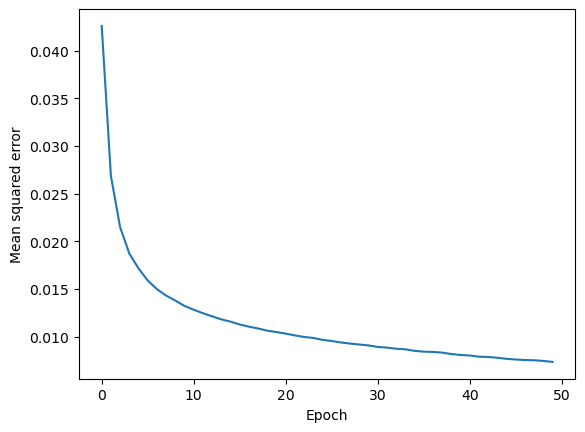

In [17]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

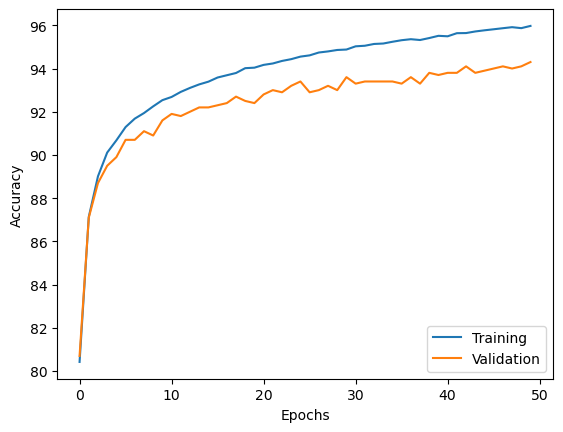

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

### Penjelasan Grafik

Grafik di atas menunjukkan perkembangan akurasi model pada data latih (Training) dan data validasi (Validation) selama 50 epoch. Terlihat bahwa pada awal epoch akurasi meningkat tajam dari sekitar 76% hingga lebih dari 85%, kemudian kenaikan menjadi lebih landai seiring bertambahnya epoch. Baik kurva training maupun validation menunjukkan tren yang konsisten meningkat hingga mencapai kisaran 95%. Perbedaan akurasi antara training dan validation relatif kecil, yang menandakan model tidak mengalami overfitting secara signifikan. Hal ini menunjukkan bahwa model mampu belajar dengan baik dari data latih dan dapat melakukan generalisasi dengan baik terhadap data validasi. Secara keseluruhan, performa model dapat dikategorikan sangat baik dengan tingkat akurasi tinggi dan stabil setelah sekitar epoch ke-30.


### Evaluasi Model pada Test Set

In [19]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test) # Silakan diisi bagian ini dengan kode yang tepat (10)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 95.82%


### Error Analysis

Kasus kesalahan prediksi (Plot failure cases):

In [20]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

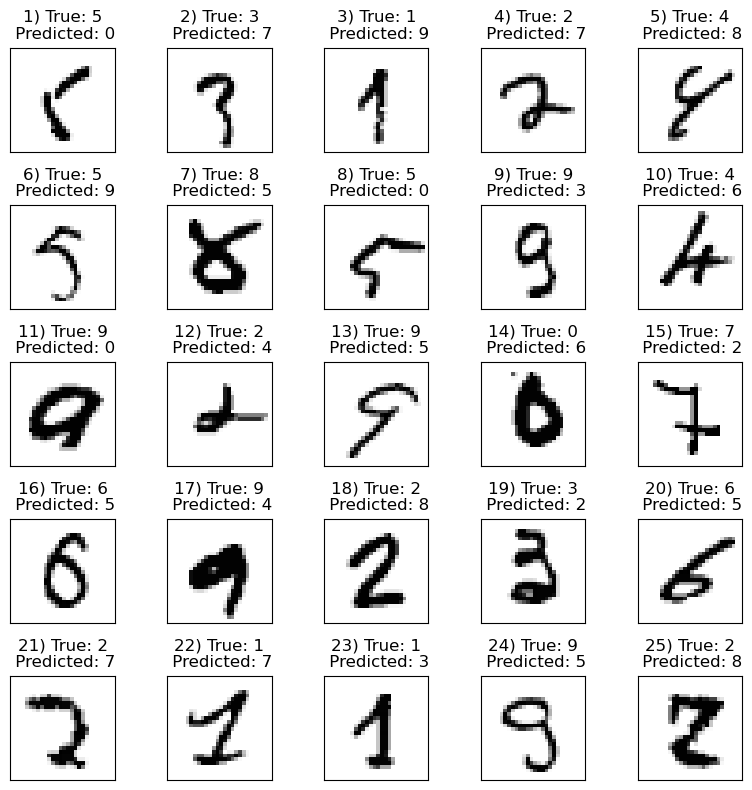

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Penjelasan Grafik

Gambar di atas menampilkan contoh kasus kesalahan prediksi model pada dataset digit tulisan tangan. Terlihat bahwa sebagian besar error terjadi karena bentuk digit yang ambigu atau mirip dengan digit lain, misalnya angka **5** yang sering diprediksi sebagai **0, 3, 4, 7, atau 9**, serta angka **9** yang diprediksi sebagai **0, 3, atau 5**. Kesalahan juga muncul pada digit dengan goresan tidak jelas atau miring, sehingga menimbulkan interpretasi berbeda oleh model, seperti angka **2** yang diprediksi sebagai **4, 7, atau 8**. Pola kesalahan ini menunjukkan bahwa model masih kesulitan membedakan digit dengan bentuk serupa atau tulisan yang kurang rapi, yang merupakan karakteristik umum pada dataset MNIST. Dengan demikian, peningkatan akurasi model dapat diarahkan melalui teknik augmentasi data untuk variasi tulisan tangan, penggunaan arsitektur model yang lebih kompleks, atau penerapan metode regularisasi yang lebih baik agar model lebih robust terhadap variasi bentuk digit.


## Training Model dengan Early Stopping

In [22]:
import numpy as np

def train_with_earlystopping(model, 
          X_train, y_train, 
          X_valid, y_valid, 
          num_epochs,
          learning_rate=0.1,
          # --- Early Stopping params ---
          early_stopping=True,
          monitor='valid_mse',     # 'valid_mse' (minimize) atau 'valid_acc' (maximize)
          patience=10,             # berapa epoch tanpa perbaikan sebelum stop
          min_delta=1e-4,          # ambang perbaikan minimal
          restore_best_weights=True,
          verbose=True):
    """
    Train model dengan opsi Early Stopping.

    Returns
    -------
    epoch_loss: list[float]        # Train MSE per-epoch
    epoch_train_acc: list[float]   # Train Acc (%) per-epoch
    epoch_valid_acc: list[float]   # Valid Acc (%) per-epoch
    best_epoch: int                # Epoch (0-based) dengan skor validasi terbaik
    """

    # Helper untuk snapshot & restore bobot model sederhana
    def _snapshot_state(m):
        return {
            'weight_h': m.weight_h.copy(),
            'bias_h':   m.bias_h.copy(),
            'weight_out': m.weight_out.copy(),
            'bias_out':   m.bias_out.copy()
        }
    def _restore_state(m, state):
        m.weight_h[:] = state['weight_h']
        m.bias_h[:]   = state['bias_h']
        m.weight_out[:] = state['weight_out']
        m.bias_out[:]   = state['bias_out']

    # Konfigurasi mode (min untuk MSE, max untuk Acc)
    if monitor == 'valid_acc':
        mode = 'max'
        best_score = -np.inf
    else:
        monitor = 'valid_mse'
        mode = 'min'
        best_score = np.inf

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    best_state = None
    best_epoch = -1
    no_improve = 0

    for e in range(num_epochs):

        # melakukan iterasi pada minibatches (potongan kecil data latih)
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Hitung keluaran (Compute outputs) ####
            a_h, a_out = model.forward(X_train_mini)

            #### Hitung gradien (Compute gradients) ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Perbarui bobot (Update weights) ####
            model.weight_h  -= learning_rate * d_loss__d_w_h
            model.bias_h    -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out   -= learning_rate * d_loss__d_b_out

        #### Pencatatan per-epoch (Epoch Logging) ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        if verbose:
            print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
                  f'| Train MSE: {train_mse:.6f} '
                  f'| Train Acc: {train_acc:.2f}% '
                  f'| Valid MSE: {valid_mse:.6f} '
                  f'| Valid Acc: {valid_acc:.2f}%')

        # --- Early Stopping check ---
        if early_stopping:
            score = valid_acc if mode == 'max' else valid_mse

            improved = (score - best_score) > min_delta if mode == 'max' else (best_score - score) > min_delta

            if improved:
                best_score = score
                best_epoch = e
                no_improve = 0
                if restore_best_weights:
                    best_state = _snapshot_state(model)
            else:
                no_improve += 1
                if no_improve >= patience:
                    if verbose:
                        print(f'Early stopping at epoch {e+1} (no improvement in {patience} epochs).')
                    break

    # Kembalikan bobot terbaik jika diminta
    if restore_best_weights and best_state is not None:
        _restore_state(model, best_state)
        if verbose:
            print(f'Restored best weights from epoch {best_epoch+1} with best {monitor}.')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, best_epoch


In [23]:
np.random.seed(123)


In [24]:
# versi lengkap dengan early stopping
epoch_loss, epoch_train_acc, epoch_valid_acc, best_epoch = train_with_earlystopping(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50,
    learning_rate=0.1,
    early_stopping=True,
    monitor='valid_mse',   # atau 'valid_acc'
    patience=5,
    min_delta=1e-4,        # jika monitor='valid_acc', contoh: 0.1 untuk 0.1 poin persen
    restore_best_weights=True,
    verbose=True
)

print("Best epoch:", best_epoch)


Epoch: 001/050 | Train MSE: 0.007328 | Train Acc: 95.99% | Valid MSE: 0.009180 | Valid Acc: 94.30%
Epoch: 002/050 | Train MSE: 0.007258 | Train Acc: 96.04% | Valid MSE: 0.009183 | Valid Acc: 94.20%
Epoch: 003/050 | Train MSE: 0.007171 | Train Acc: 96.11% | Valid MSE: 0.009047 | Valid Acc: 94.30%
Epoch: 004/050 | Train MSE: 0.007141 | Train Acc: 96.12% | Valid MSE: 0.009049 | Valid Acc: 94.00%
Epoch: 005/050 | Train MSE: 0.007068 | Train Acc: 96.13% | Valid MSE: 0.009008 | Valid Acc: 94.40%
Epoch: 006/050 | Train MSE: 0.007031 | Train Acc: 96.17% | Valid MSE: 0.008937 | Valid Acc: 94.40%
Epoch: 007/050 | Train MSE: 0.006924 | Train Acc: 96.27% | Valid MSE: 0.008837 | Valid Acc: 94.40%
Epoch: 008/050 | Train MSE: 0.006903 | Train Acc: 96.22% | Valid MSE: 0.008964 | Valid Acc: 94.20%
Epoch: 009/050 | Train MSE: 0.006893 | Train Acc: 96.29% | Valid MSE: 0.008822 | Valid Acc: 94.80%
Epoch: 010/050 | Train MSE: 0.006799 | Train Acc: 96.29% | Valid MSE: 0.008792 | Valid Acc: 94.60%
Epoch: 011

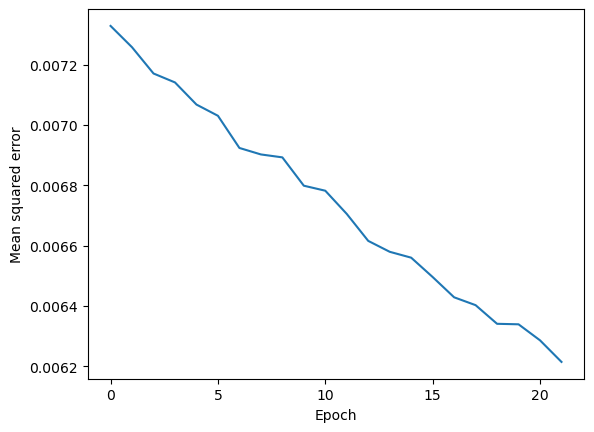

In [25]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

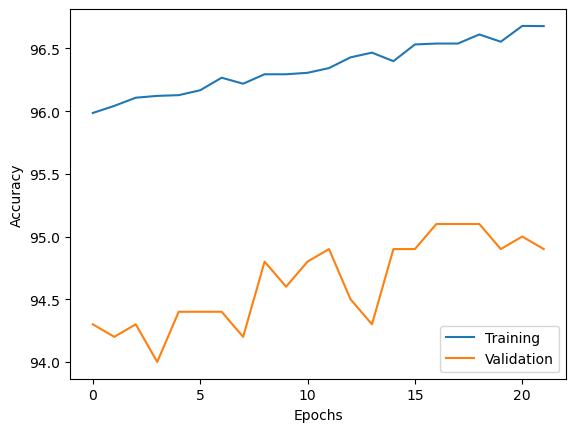

In [26]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [27]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 96.34%


In [28]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

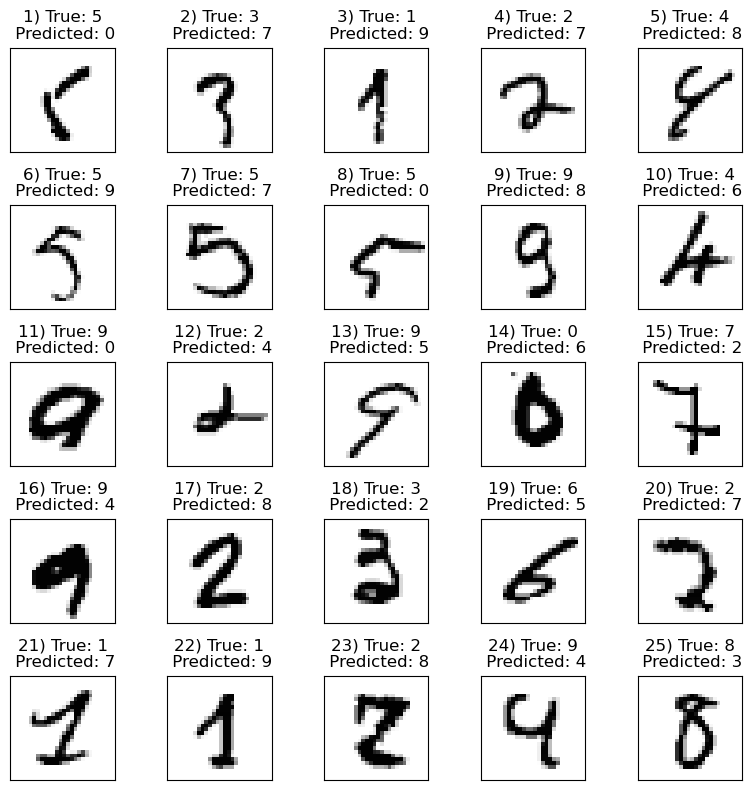

In [29]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()